 # Imbalance classfication problem -- (Code Challenge)
 The jupyter notebook includes all related algorithms and results to load dataset, visualize principal conponents, and then, prediting the data's label using Logistic regression and a designed neural network.

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


NUM_PCA_COMPONENT: int = 2
PCA_VARIANCE: np.float = 0.95
NUM_LDA_COMPONENT: int = 2

def get_data() -> List[pd.DataFrame]:
    input_train_data = pd.read_csv('train_x.csv')
    output_train_data = pd.read_csv('train_y.csv')
    input_test_data = pd.read_csv('test_x.csv')
    return input_train_data, output_train_data, input_test_data


def standardize_data(input_train_data: pd.DataFrame, input_test_data: pd.DataFrame) -> List[np.ndarray]:
    in_train = StandardScaler().fit_transform(input_train_data)
    in_test = StandardScaler().fit_transform(input_test_data)
    return in_train, in_test


def project_data(data: pd.DataFrame) -> pd.DataFrame:
    pca = PCA(n_components=NUM_PCA_COMPONENT)
    principalComponents = pca.fit_transform(data)
    principalDf = pd.DataFrame(data = principalComponents,
                                columns = ['principal component 1', 'principal component 2'])
    return principalDf, pca


def visualize_data_pca(final_df: pd.DataFrame) -> plt.plot:
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = [1, 0]
    colors = ['g', 'r']
    for target, color in zip(targets,colors):
        indicesToKeep = final_df['target'] == target
        ax.scatter(final_df.loc[indicesToKeep, 'principal component 1'],
                    final_df.loc[indicesToKeep, 'principal component 2'],
                    c = color,
                    s = 50)
    ax.legend(targets)
    ax.grid()


def visualize_data_lda(input_train_data: pd.DataFrame, out_train_data: pd.DataFrame) -> plt.plot:
    y = out_train_data.target
    X = input_train_data
    y.loc[4001] = y.loc[2] + 2
    X.loc[4001] = input_train_data.loc[0] * 10

    lda = LinearDiscriminantAnalysis(n_components=2)
    X_r = lda.fit(X, y).transform(X)
    colors = ['navy', 'red']
    target_names = ['False', 'True']
    plt.figure()
    for color, i, target_name in zip(colors, [0, 1], target_names):
        plt.scatter(X_r[y == i, 0], X_r[y == i, 1], alpha=.8, color=color,
                    label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('LDA of data')
    plt.grid()
    plt.show()

# Visualize Principal Components
In this step, the train data and test data will be loaded, then, they shoudl be normalized in order to avoid any problem in not only learning phase but also in computing principal components. Eventually, they data will be shown by considering principal components.

Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales. Although, all features in the Iris dataset were measured in centimeters, let us continue with the transformation of the data onto unit scale (mean=0 and variance=1), which is a requirement for the optimal performance of many machine learning algorithms.


Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like standard normally distributed data.

Here we plot the different samples on the 2 first principal components.

In [ ]:
input_train_data, out_train_data, input_test_data = get_data()
in_train, in_test = standardize_data(input_train_data, input_test_data)
principal_df, pca = project_data(in_train)
final_df = pd.concat([principal_df, out_train_data[['target']]], axis = 1)
visualize_data_pca(final_df)
print(f"The pca's variance ratio is {pca.explained_variance_ratio_}")

# Applying PCA to the Data
Principal Component Analysis (PCA) applied to this data identifies the combination of attributes (principal components, or directions in the feature space) that account for the most variance in the data.

In [ ]:
pca = PCA(PCA_VARIANCE)
pca.fit(in_train)
print(f"Num of principal components is {pca.n_components_}")
train_ = pca.transform(in_train)
test_ = pca.transform(in_test)

# Linear Discriminant Analysis (LDA)
LDA tries to identify attributes that account for the most variance between classes. In particular, LDA, in contrast to PCA, is a supervised method, using known class labels.


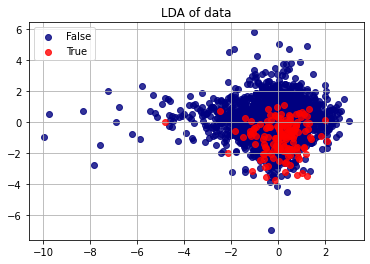

In [52]:
visualize_data_lda(input_train_data, out_train_data)

# Logistic Regression
The fitting problem for train data will be computed by using Logistic Regression in this step. Then, the fitting accuracy will be computed for the seperated test data.

accuracy (fraction of correct predictions): correct predictions / total number of data points

In [ ]:
train_1, test_1, train_lbl, test_lbl = train_test_split(train_, out_train_data.target, test_size=1/8.0, random_state=0)
logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(train_1, train_lbl)
score = logisticRegr.score(test_1, test_lbl)
print(f"The prediction score is {score}")

# Predcit data
The target for the test data will be calculated using the obtained parameters in LogisticRegression. Then, the result is saved as a CSV file.

In [ ]:
predicted_test = logisticRegr.predict(test_)
test_y = pd.DataFrame(predicted_test, columns=['target'])
test_y['Unnamed: 0'] = out_train_data['Unnamed: 0']
test_y = test_y[['Unnamed: 0', 'target']]
test_y.to_csv('test_y.csv')
test_y.head(8) 